In [4]:
import json
import re
import unicodedata
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm.auto import tqdm

D:\SciSumm-RAG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
def find_project_root(cur_dir: Path) -> Path:
    for parent in [cur_dir] + list(cur_dir.parents):
        if (parent / "data" / "raw").exists():
            return parent
    raise FileNotFoundError("Project root not found")

In [26]:
cwd = Path().resolve()
BASE_DIR = find_project_root(cwd)
file_path = BASE_DIR / "data" / "raw" / "arxiv" / "arxiv-metadata-oai-snapshot.json"
if not file_path.exists():
    raise FileNotFoundError(f"File not found: {file_path}")

In [27]:
records = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading JSONL"):
        obj = json.loads(line)
        rec = obj.get("root", obj)
        versions = rec.get("versions", [])
        year = None
        if isinstance(versions, list) and versions and "created" in versions[0]:
            try:
                year = int(versions[0]["created"][:4])
            except:
                year = None
        records.append({
            "paper_id": rec.get("id"),
            "submitter": rec.get("submitter"),
            "authors": rec.get("authors"),
            "title": rec.get("title"),
            "categories": rec.get("categories"),
            "year": year,
            "full_text": rec.get("abstract", "") or ""
        })

Loading JSONL: 2771128it [00:28, 98245.61it/s] 


In [50]:
df = pd.DataFrame(records)

In [33]:
df.head(5)

,paper_id,submitter,authors,title,categories,year,full_text
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,None,A fully differential calculation in perturba...
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,None,"We describe a new algorithm, the $(k,\ell)$-..."
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,None,The evolution of Earth-Moon system is descri...
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,None,We show that a determinant of Stirling cycle...
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,None,In this paper we show how to compute the $\L...


In [35]:
df.isnull()

,paper_id,submitter,authors,title,categories,year,full_text
0,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...
2771123,False,False,False,False,False,True,False
2771124,False,False,False,False,False,True,False
2771125,False,False,False,False,False,True,False
2771126,False,False,False,False,False,True,False


In [36]:
df.describe()

,paper_id,submitter,authors,title,categories,year,full_text
count,2771128,2755939,2771128,2771128,2771128,0,2771128
unique,2771104,574134,2178104,2766890,90821,0,2769308
top,math-ph/0512019,EPTCS,CMS Collaboration,Discussion of: A statistical analysis of multi...,astro-ph,NaN,This paper has been withdrawn.\n
freq,4,4012,1361,12,86911,NaN,91


In [37]:
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771128 entries, 0 to 2771127
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   paper_id    object
 1   submitter   object
 2   authors     object
 3   title       object
 4   categories  object
 5   year        object
 6   full_text   object
dtypes: object(7)
memory usage: 148.0+ MB
None

Missing values per column:
paper_id            0
submitter       15189
authors             0
title               0
categories          0
year          2771128
full_text           0
dtype: int64


In [38]:
print("\nNumeric summary:")
print(df.describe())


Numeric summary:
               paper_id submitter            authors  \
count           2771128   2755939            2771128   
unique          2771104    574134            2178104   
top     math-ph/0512019     EPTCS  CMS Collaboration   
freq                  4      4012               1361   

                                                    title categories year  \
count                                             2771128    2771128    0   
unique                                            2766890      90821    0   
top     Discussion of: A statistical analysis of multi...   astro-ph  NaN   
freq                                                   12      86911  NaN   

                                 full_text  
count                              2771128  
unique                             2769308  
top       This paper has been withdrawn.\n  
freq                                    91  


In [39]:
print("\nUnique counts for all columns:")
print(df.nunique())


Unique counts for all columns:
paper_id      2771104
submitter      574134
authors       2178104
title         2766890
categories      90821
year                0
full_text     2769308
dtype: int64


In [40]:
display(df.head())
display(df.tail())

,paper_id,submitter,authors,title,categories,year,full_text
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,None,A fully differential calculation in perturba...
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,None,"We describe a new algorithm, the $(k,\ell)$-..."
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,None,The evolution of Earth-Moon system is descri...
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,None,We show that a determinant of Stirling cycle...
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,None,In this paper we show how to compute the $\L...


,paper_id,submitter,authors,title,categories,year,full_text
2771123,supr-con/9608008,Ruslan Prozorov,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,None,We report on measurements of the angular dep...
2771124,supr-con/9609001,Durga P. Choudhury,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,None,The non-linear microwave surface impedance o...
2771125,supr-con/9609002,Durga P. Choudhury,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,None,The vortex contribution to the dc field (H) ...
2771126,supr-con/9609003,Hasegawa Yasumasa,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,None,We show that the density of states in an ani...
2771127,supr-con/9609004,Masanori Ichioka,"Naoki Enomoto, Masanori Ichioka and Kazushige ...",Ginzburg Landau theory for d-wave pairing and ...,supr-con cond-mat.supr-con,None,The Ginzburg Landau theory for d_{x^2-y^2}-w...


In [51]:

def infer_year_from_id(pid: str) -> int | None:
    # new style: YYMM.NNNN or YYMM.NNNNvV
    m = re.match(r'^(\d{2})(\d{2})\.\d+', pid)
    if m:
        yy, mm = m.groups()
        year = 2000 + int(yy)
        return year
    # legacy style: archive/YYMMNNN
    m = re.match(r'^[a-z\-]+/(\d{2})(\d{2})\d+', pid)
    if m:
        yy, mm = m.groups()
        return 1900 + int(yy) if int(yy) >= 90 else 2000 + int(yy)
    return None

df['year'] = df['paper_id'].apply(infer_year_from_id)
df = df[df['year'].notna()]
df['year'] = df['year'].astype(int)

In [52]:
df['submitter'] = df['submitter'].fillna('unknown')
df = df.drop_duplicates(subset='paper_id', keep='first')

In [53]:
df['authors_list']    = df['authors'].str.split('; ')
df['categories_list'] = df['categories'].str.split('; ')

In [55]:
df['n_authors']     = df['authors_list'].str.len()
df['n_categories']  = df['categories_list'].str.len()
df['title_length']  = df['title'].str.len()
df['abstract_length'] = df['full_text'].str.len()

In [56]:
df = df[df['abstract_length'] >= 50]

In [47]:
# 1) Basic info & types
print("DataFrame info:")
print(df.info(), "\n")

# 2) Missing values per column
print("Missing values:")
print(df.isna().sum(), "\n")

# 3) Duplicate check on paper_id
dups = df.duplicated(subset='paper_id').sum()
print(f"Duplicate paper_id rows: {dups}\n")

# 4) Data types
print("Column dtypes:")
print(df.dtypes, "\n")

# 5) Descriptive stats
print("Descriptive statistics (numeric features):")
print(df[['year','n_authors','n_categories','title_length','abstract_length']].describe(), "\n")

print("Descriptive statistics (object features):")
print(df[['submitter']].describe(), "\n")

# 6) Quick peek at head and tail
print("First 5 rows:")
display(df.head())

print("Last 5 rows:")
display(df.tail())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 2770318 entries, 0 to 2771127
Data columns (total 13 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   paper_id         object
 1   submitter        object
 2   authors          object
 3   title            object
 4   categories       object
 5   year             int64 
 6   full_text        object
 7   authors_list     object
 8   categories_list  object
 9   n_authors        int64 
 10  n_categories     int64 
 11  title_length     int64 
 12  abstract_length  int64 
dtypes: int64(5), object(8)
memory usage: 295.9+ MB
None 

Missing values:
paper_id           0
submitter          0
authors            0
title              0
categories         0
year               0
full_text          0
authors_list       0
categories_list    0
n_authors          0
n_categories       0
title_length       0
abstract_length    0
dtype: int64 

Duplicate paper_id rows: 0

Column dtypes:
paper_id           object
submitter

,paper_id,submitter,authors,title,categories,year,full_text,authors_list,categories_list,n_authors,n_categories,title_length,abstract_length
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,2007,A fully differential calculation in perturba...,"[C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C....",[hep-ph],1,1,87,983
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,2007,"We describe a new algorithm, the $(k,\ell)$-...",[Ileana Streinu and Louis Theran],[math.CO cs.CG],1,1,40,798
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,2007,The evolution of Earth-Moon system is descri...,[Hongjun Pan],[physics.gen-ph],1,1,83,880
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,2007,We show that a determinant of Stirling cycle...,[David Callan],[math.CO],1,1,89,248
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,2007,In this paper we show how to compute the $\L...,[Wael Abu-Shammala and Alberto Torchinsky],[math.CA math.FA],1,1,52,223


Last 5 rows:


,paper_id,submitter,authors,title,categories,year,full_text,authors_list,categories_list,n_authors,n_categories,title_length,abstract_length
2771123,supr-con/9608008,Ruslan Prozorov,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,1996,We report on measurements of the angular dep...,"[R. Prozorov, M. Konczykowski, B. Schmidt, Y. ...",[supr-con cond-mat.supr-con],1,1,99,516
2771124,supr-con/9609001,Durga P. Choudhury,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,1996,The non-linear microwave surface impedance o...,"[Durga P. Choudhury, Balam A. Willemsen, John ...",[supr-con cond-mat.supr-con],1,1,91,647
2771125,supr-con/9609002,Durga P. Choudhury,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,1996,The vortex contribution to the dc field (H) ...,"[Balam A. Willemsen, J. S. Derov and S.Sridhar...",[supr-con cond-mat.supr-con],1,1,96,1097
2771126,supr-con/9609003,Hasegawa Yasumasa,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,1996,We show that the density of states in an ani...,[Yasumasa Hasegawa (Himeji Institute of Techno...,[supr-con cond-mat.supr-con],1,1,105,635
2771127,supr-con/9609004,Masanori Ichioka,"Naoki Enomoto, Masanori Ichioka and Kazushige ...",Ginzburg Landau theory for d-wave pairing and ...,supr-con cond-mat.supr-con,1996,The Ginzburg Landau theory for d_{x^2-y^2}-w...,"[Naoki Enomoto, Masanori Ichioka and Kazushige...",[supr-con cond-mat.supr-con],1,1,88,695


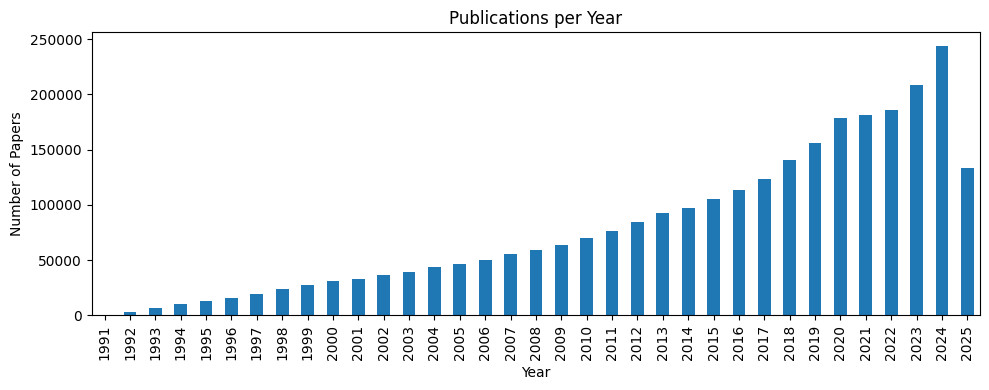

In [58]:
plt.figure(figsize=(10,4))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title("Publications per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.tight_layout()
plt.show()

In [59]:
import seaborn as sns

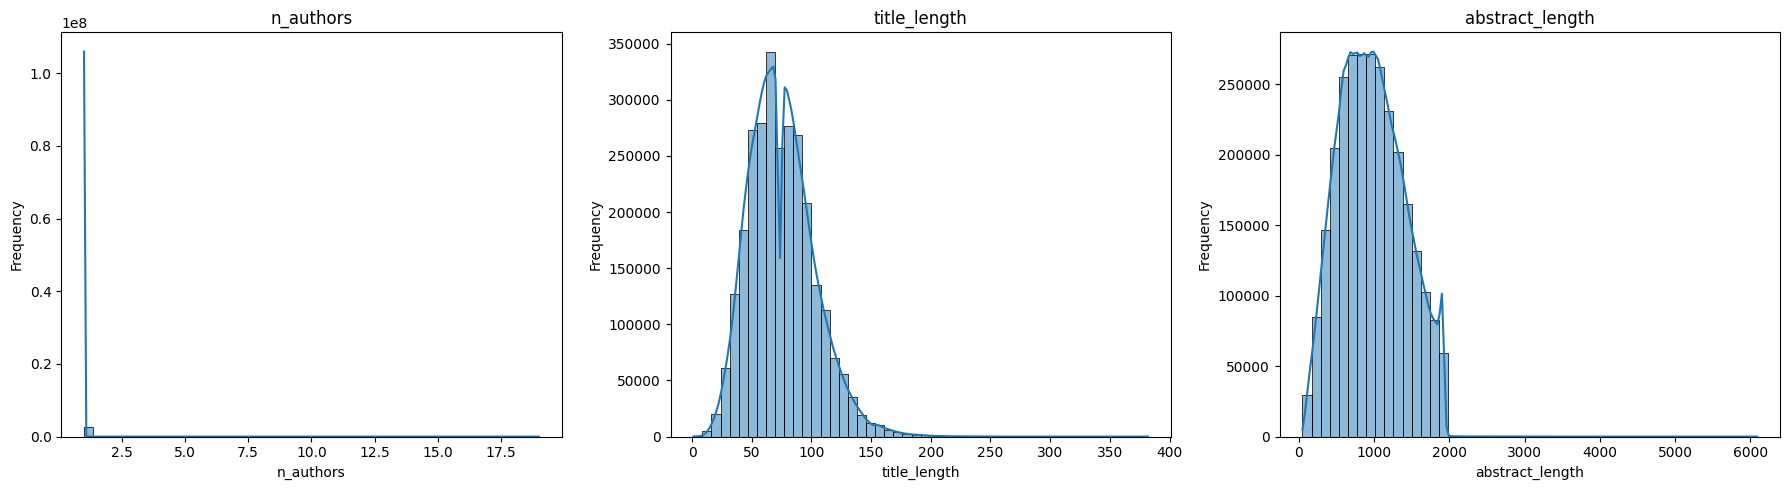

In [60]:
num_cols = ['n_authors', 'title_length', 'abstract_length']
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

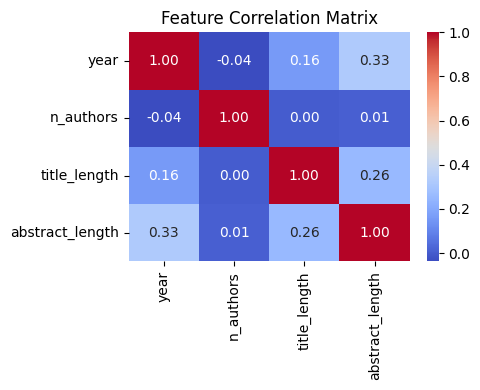

In [61]:
corr = df[['year', 'n_authors', 'title_length', 'abstract_length']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

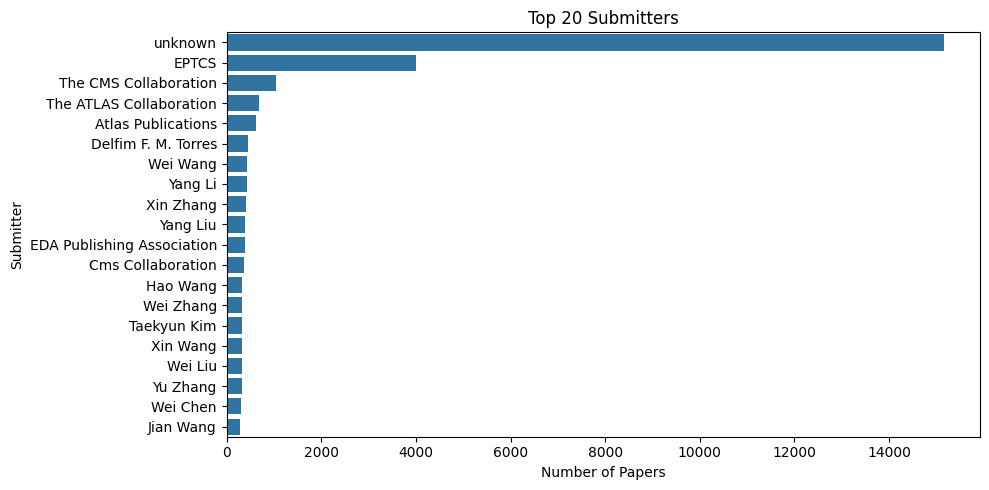

In [62]:
top_submitters = df['submitter'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=top_submitters.values, y=top_submitters.index)
plt.title("Top 20 Submitters")
plt.xlabel("Number of Papers")
plt.ylabel("Submitter")
plt.tight_layout()
plt.show()

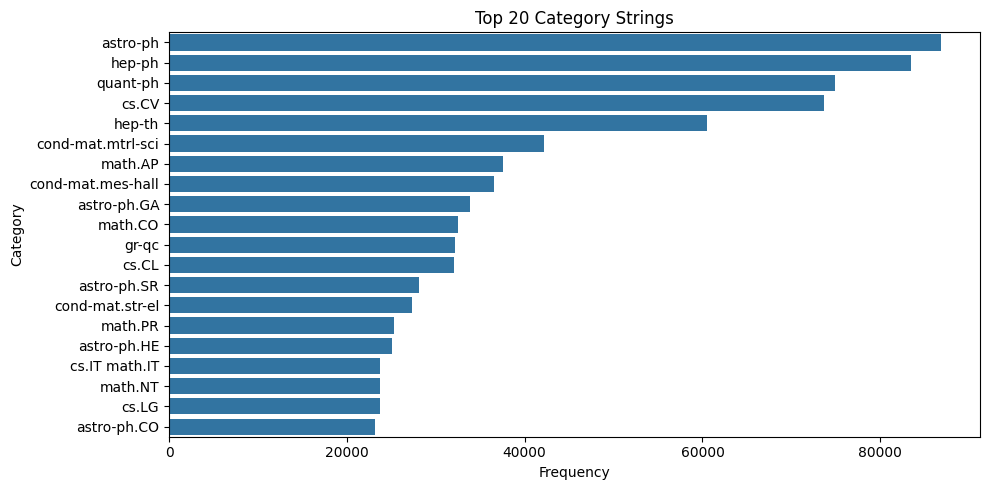

In [63]:
top_cats = df['categories'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title("Top 20 Category Strings")
plt.xlabel("Frequency")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

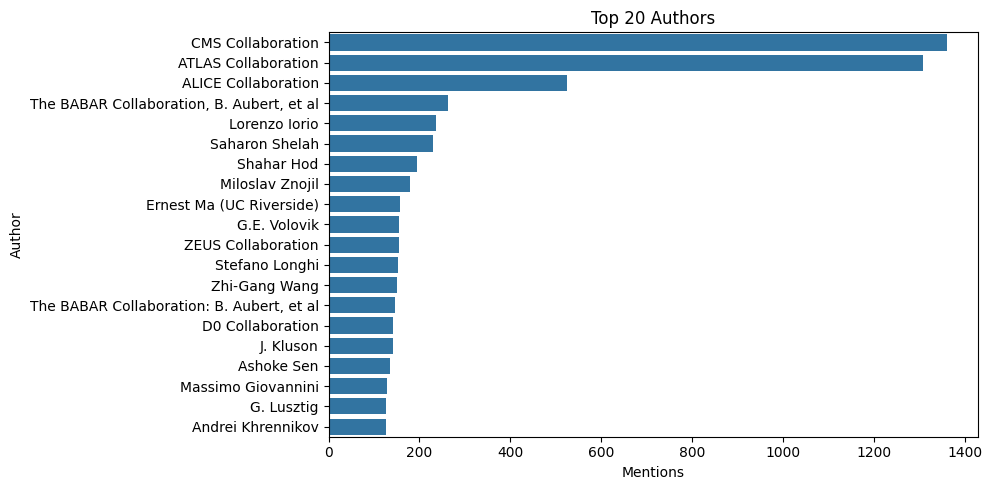

In [64]:
authors_exploded = df['authors'].str.split('; ').explode()
top_authors = authors_exploded.value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title("Top 20 Authors")
plt.xlabel("Mentions")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

In [ ]:
BASE_DIR = find_project_root(Path().resolve())
clean_dir = BASE_DIR / "data" / "clean"
clean_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
df2 = df.copy()
df2['authors'] = df2['authors_list'].apply(lambda lst: "; ".join(lst))
df2['categories'] = df2['categories_list'].apply(lambda lst: "; ".join(lst))
df2 = df2[['paper_id', 'title', 'authors', 'year', 'categories', 'full_text']]
df2.to_csv(clean_dir / "metadata_clean.csv", index=False, encoding='utf-8')